# Learning a Neural GSM model

In [23]:
import jax
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
jax.config.update("jax_platform_name", "cpu") # cpu
import jaxmat.materials as jm
from jaxmat.state import make_batched, AbstractState, SmallStrainState
from jaxmat.tensors import SymmetricTensor2, main_invariants
from jaxmat.nn.icnn import ICNN
import equinox as eqx
from pathlib import Path
from utils import load_from_hdf5
import optax


key = jax.random.PRNGKey(42)
key1, key2,key3 = jax.random.split(key, num=3)
hdf5_path = Path("./data/dataset_vel2phhs_relax_3D.h5")#")#/DISK2/md266594/Workspace/pt2mfront/data/dataset_maxwell_3D.h5")#../data/dataset_vel2phhs_3D.h5")#../data/dataset_vel2phhs_relax_3D.h5")

# load training data
strain, stress, _, _, iv, times, metadata, scalers, config, material_infos = load_from_hdf5(
            hdf5_path, "train"
        )
strain_test, stress_test, _, _, _, times_test, metadata, scalers, config, material_infos_test = load_from_hdf5(
            hdf5_path, "test"
        )

times = jnp.array(times)

# normalization
strain /= scalers["std_strain"]
stress /= scalers["std_stress"]
strain_test /= scalers["std_strain"]
stress_test /= scalers["std_stress"]
psi, phi = iv[:,:,-2],iv[:,:,-1] 

In [24]:
strain.shape

(10, 41, 6)

In [25]:
train_strain = SymmetricTensor2.from_voigt(strain)
train_stress = SymmetricTensor2.from_voigt(stress)
test_strain = SymmetricTensor2.from_voigt(strain_test)
test_stress = SymmetricTensor2.from_voigt(stress_test)

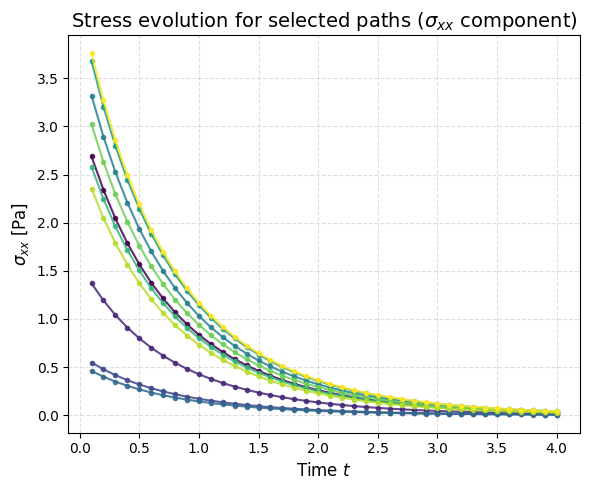

In [26]:
# Nombre de chemins à afficher
n_paths = 10
colors = plt.cm.viridis(jnp.linspace(0, 1, n_paths))

fig, ax = plt.subplots(figsize=(6, 5))

# Composante XY (Voigt index 0)
k,l = 0,1  # XY

for i in range(n_paths):
    ax.plot(
        times[i, 1:],               # temps
        train_stress[i, 1:, k,l],     # σ_xy
        color=colors[i],
        marker='o',
        markersize=3,
        linewidth=1.5,
        alpha=0.85,
    )

ax.set_xlabel("Time $t$", fontsize=12)
ax.set_ylabel(r"$\sigma_{xx}$ [Pa]", fontsize=12)
ax.set_title("Stress evolution for selected paths ($\sigma_{xx}$ component)", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.4)

fig.tight_layout()
plt.show()

In [27]:
from optax.tree_utils import tree_scale, tree_sub
# define evolution function 

@eqx.filter_jit
def compute_evolution(material, epsilons, times, return_potential=True):
    # Initial material state
    state0 = material.init_state()
    dt = jnp.diff(times)

    def step(state, args):
        eps_new, dt_ = args

        # Constitutive update (Newton local)
        sig_new, new_state = material.constitutive_update(eps_new, state, dt_)

        if return_potential:
            # Free energy at n+1
            free_energy = material.free_energy(eps_new, new_state.internal)

            # Internal variable rate
            d_isv = tree_sub(new_state.internal, state.internal)
            isv_dot = tree_scale(1.0 / dt_, d_isv)

            # Dissipative thermodynamic force
            A_dis = jax.grad(material.free_energy, argnums=1)(
                eps_new, new_state.internal
            )
            A_dis = tree_scale(-1,A_dis)

            # Dissipation: A_dis · isv_dot
            dissipation = jnp.sum(A_dis.alpha * isv_dot.alpha) 

            return new_state, (
                sig_new,
                free_energy,
                dissipation,
                isv_dot,
                new_state.internal,
            )
        else:
            return new_state, sig_new

    if return_potential:
        _, (sig, free_energy, dissipation, isv_dot, isv) = jax.lax.scan(
            step, state0, (epsilons, dt)
        )
        return sig, free_energy, dissipation, isv_dot, isv
    else:
        _, sig = jax.lax.scan(step, state0, (epsilons, dt))
        return sig

batched_compute_evolution = jax.vmap(
    compute_evolution,
    in_axes=(None, 0, 0, None),
)


In [28]:
# Define the GSM internal variable state
class InternalState(AbstractState):
    alpha: SymmetricTensor2 = eqx.field(init=False)
    """Viscoelastic strains."""
    Nvar: int = eqx.field(static=True, default=1)
    """Number of viscoelastic variables."""
    
    def __post_init__(self):
        self.alpha = make_batched(SymmetricTensor2(), self.Nvar)

In [29]:
# Define the free energy
class FreeEnergy(eqx.Module):
    elasticity: jm.AbstractLinearElastic
    viscous_model: list[jm.AbstractLinearElastic]

    def __call__(self, eps, isv):

        alpha = isv.alpha
        psi_el = 0.5 * jnp.trace(eps @ (self.elasticity.C @ eps))

        def viscous_free_energy(viscous_model, alpha):
            eps_el = eps - alpha
            return 0.5 * jnp.trace(eps_el @ (viscous_model.C @ eps_el))

        psi_v = jnp.sum(jax.vmap(viscous_free_energy)(self.viscous_model, alpha))
        return psi_v + psi_el 

In [30]:
# Define the dissipation potential
class ICNNDissipationPotential(ICNN):
    def icnn_potential(self, A_dis):
        I1, I2, I3 = jax.vmap(main_invariants)(A_dis)
        x = jnp.concatenate([
            I2,
        ], axis=0)
        return super().__call__(x)

    def __call__(self, A_dis):
        A_dis = A_dis.alpha.tensor
        return (
            self.icnn_potential(A_dis)
            - jax.jvp(self.icnn_potential, (jnp.zeros_like(A_dis),), (A_dis,))[
                1
            ]
        )


In [31]:
Nvar = 3
hidden_dims = [8,8]
icnn_dual_dissipation_potential = ICNNDissipationPotential(Nvar, hidden_dims, key1)
E1_ = jax.random.lognormal(key2, shape=(Nvar,)) * 0.1 / Nvar
E0_ = 0.1 
nu = 0.31 
viscous_model = jm.LinearElasticIsotropic(E1_, jnp.full_like(E1_, fill_value=-0.13))
elasticity = jm.LinearElasticIsotropic(E0_, nu)
free_energy = FreeEnergy(elasticity=elasticity, viscous_model=viscous_model)

class GSM(jm.GeneralizedStandardMaterialDual):
    def make_internal_state(self):
        return InternalState(Nvar=Nvar)
    
    def stress(self,epsilon, alpha):
        return jax.jacfwd(self.free_energy, argnums=0)(epsilon, alpha)
    
gsm = GSM(
    free_energy=free_energy,
    dual_dissipation_potential=icnn_dual_dissipation_potential,
)

In [32]:
epsilons_train = SymmetricTensor2(train_strain[:,1:,...])
sig_gt= SymmetricTensor2(train_stress[:,1:,...])
times_train = times
print(epsilons_train, times_train.shape)
sig_train = batched_compute_evolution(gsm,epsilons_train, times_train, False)
times.shape

SymmetricTensor2(dim=3, rank=2, _tensor=f64[10,40,3,3]) (10, 41)


(10, 41)

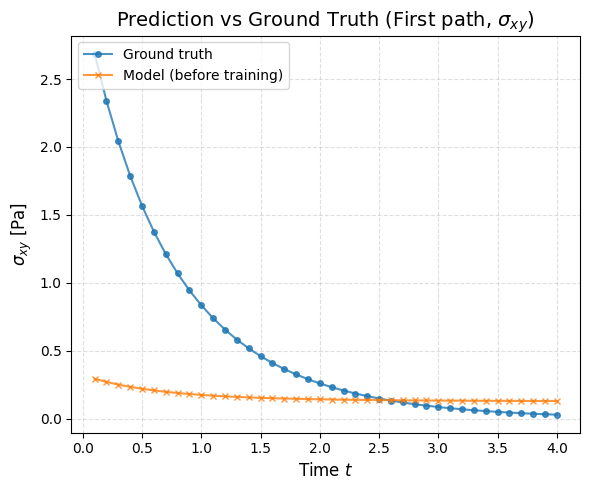

In [33]:
i_path = 0

plt.figure(figsize=(6, 5))

# Ground truth
plt.plot(
    times_train[i_path, 1:], 
    sig_gt[i_path, :, 0, 1], 
    marker='o', markersize=4, linewidth=1.5, alpha=0.8,
    label="Ground truth"
)

# Prediction before training
plt.plot(
    times_train[i_path, 1:], 
    sig_train[i_path, :, 0, 1], 
    marker='x', markersize=4, linewidth=1.5, alpha=0.8,
    label="Model (before training)"
)

plt.xlabel("Time $t$", fontsize=12)
plt.ylabel(r"$\sigma_{xy}$ [Pa]", fontsize=12)
plt.title("Prediction vs Ground Truth (First path, $\sigma_{xy}$)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

## Training

In [34]:
sig_noise = SymmetricTensor2(tensor=sig_gt) 

learning_rate = 1e-2
max_steps = 1000
optimizer = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_param_block_rms(),
    optax.scale(-learning_rate),
)

# --- Loss function ---
@eqx.filter_jit
def loss_fn(params, args):
    sig_data, static_ = args
    material_ = params if static_ is None else eqx.combine(params, static_)
    sig_hat = batched_compute_evolution(material_, epsilons_train, times_train, False)
    diff = sig_hat.tensor - sig_data.tensor
    loss_val = 0.5 * jnp.mean(diff**2)
    return loss_val, sig_hat

# --- Gradient step ---
@jax.jit
def step(params, opt_state, args):
    (loss_val, sig_hat), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, args)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val, sig_hat

trainable, static = eqx.partition(gsm, eqx.is_array)
print(f"Train with Nvar={Nvar}")

# initialisation optimizer
params = trainable
opt_state = optimizer.init(params)

# Training loop
for step_idx in range(max_steps):
    params, opt_state, loss_val, sig_hat_train = step(params, opt_state, (sig_noise, static))

    if step_idx % 50 == 0:
        print(f"[Nvar={Nvar}] Step {step_idx}: loss = {float(loss_val):.6e}")

# Combine trainable + static 
trained_material = params if static is None else eqx.combine(params, static)


Train with Nvar=3
[Nvar=3] Step 0: loss = 6.129157e-02
[Nvar=3] Step 50: loss = 4.319213e-02
[Nvar=3] Step 100: loss = 2.174726e-02
[Nvar=3] Step 150: loss = 2.958372e-03
[Nvar=3] Step 200: loss = 1.688969e-03
[Nvar=3] Step 250: loss = 1.079987e-03
[Nvar=3] Step 300: loss = 7.396163e-04
[Nvar=3] Step 350: loss = 5.303829e-04
[Nvar=3] Step 400: loss = 3.939516e-04
[Nvar=3] Step 450: loss = 3.011445e-04
[Nvar=3] Step 500: loss = 2.357747e-04
[Nvar=3] Step 550: loss = 1.883516e-04
[Nvar=3] Step 600: loss = 1.530856e-04
[Nvar=3] Step 650: loss = 1.263079e-04
[Nvar=3] Step 700: loss = 1.056123e-04
[Nvar=3] Step 750: loss = 8.937269e-05
[Nvar=3] Step 800: loss = 7.646071e-05
[Nvar=3] Step 850: loss = 6.607579e-05
[Nvar=3] Step 900: loss = 5.763845e-05
[Nvar=3] Step 950: loss = 5.072187e-05


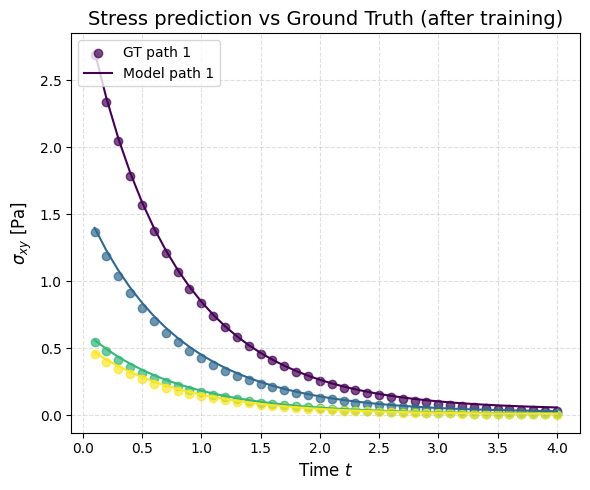

In [35]:

n_paths = 4  # nombre de chemins à afficher
colors = plt.cm.viridis(jnp.linspace(0, 1, n_paths))  # couleurs dégradées

plt.figure(figsize=(6, 5))

for i in range(n_paths):
    # Ground truth (scatter)
    plt.scatter(
        times_train[i, 1:], 
        train_stress[i, 1:, 0, 1], 
        color=colors[i],
        alpha=0.7,
        marker='o',
        label=f'GT path {i+1}' if i == 0 else None  # label unique pour la légende
    )
    
    # Model predictions (line)
    plt.plot(
        times_train[i, 1:], 
        sig_hat_train[i, :, 0, 1], 
        color=colors[i],
        linewidth=1.5,
        label=f'Model path {i+1}' if i == 0 else None
    )

plt.xlabel("Time $t$", fontsize=12)
plt.ylabel(r"$\sigma_{xy}$ [Pa]", fontsize=12)
plt.title("Stress prediction vs Ground Truth (after training)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

## Export to Tensorflow

Our goal is now to export the material model to MFront. The idea is to export from `gsm` several functions especially `stress`, `tangentop` and also `dalpha`.

In [36]:
def stress_fn(epsilon:jnp.array, alpha:jnp.array):
    '''
    function that take the 6 composant of epsilon in voigt notation as well as alpha does.'''
    # epsilon = jnp.asarray(epsilon)
    # alpha = jnp.asarray(alpha)
    epsilon /= scalers["std_strain"]
    epsilon_ = SymmetricTensor2.from_voigt(epsilon)
    isv = InternalState(Nvar=Nvar)
    isv = isv.update(alpha=SymmetricTensor2.from_voigt(alpha))
    return trained_material.stress(epsilon_, isv).to_voigt() * scalers["std_stress"]

def tangentop_fn(epsilon:jnp.array, alpha:jnp.array):
    '''function that take the 6 composant of epsilon in voigt notation as well as alpha does.'''
    C = jax.jacfwd(stress_fn)(epsilon, alpha)
    return C

def dalpha_fn(epsilon:jnp.array, alpha:jnp.array):
    epsilon /= scalers["std_strain"]
    epsilon_ = SymmetricTensor2.from_voigt(epsilon)
    isv = InternalState(Nvar=Nvar)
    isv = isv.update(alpha=SymmetricTensor2.from_voigt(alpha))
    A_dis = jax.jacfwd(trained_material.free_energy, argnums=1)(epsilon_, isv)
    A_dis = tree_scale(-1, A_dis)
    dalpha = jax.grad(trained_material.dual_dissipation_potential)(A_dis).alpha.to_voigt()
    return dalpha

In [37]:
state = gsm.init_state()
alpha = jax.random.normal(key=key1, shape=(3,6))
epsilon = jax.random.normal(key=key1, shape=(6,))

print(stress_fn(epsilon, alpha))
print(tangentop_fn(epsilon, alpha))
print(dalpha_fn(epsilon, alpha).shape)

[-1.19220567e+00 -1.21992265e+00  2.86089680e+00 -4.53841353e+10
  7.47672986e-01  2.32499486e+00]
[[ 1.46960331e+00 -4.86353424e-01 -4.86353424e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.86353424e-01  1.46960331e+00 -4.86353424e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.86353424e-01 -4.86353424e-01  1.46960331e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.54376167e+11
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.95595673e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.95595673e+00]]
(3, 6)


In [38]:
from jax.experimental import jax2tf
import tensorflow as tf
# Conversion JAX → TF
stress_tf = tf.function(jax2tf.convert(stress_fn, with_gradient=False, enable_xla=False), 
                        input_signature=[
        tf.TensorSpec(shape=(6,), dtype=tf.float64, name="epsilon"),
        tf.TensorSpec(shape=(Nvar, 6), dtype=tf.float64, name="alpha"),
    ],)
tangentop_tf = tf.function(jax2tf.convert(tangentop_fn, with_gradient=False, enable_xla=False), 
                        input_signature=[
        tf.TensorSpec(shape=(6,), dtype=tf.float64, name="epsilon"),
        tf.TensorSpec(shape=(Nvar, 6), dtype=tf.float64, name="alpha"),
    ],)
dalpha_tf = tf.function(jax2tf.convert(dalpha_fn, with_gradient=False, enable_xla=False), 
                    input_signature=[
        tf.TensorSpec(shape=(6,), dtype=tf.float64, name="epsilon"),
        tf.TensorSpec(shape=(Nvar, 6), dtype=tf.float64, name="alpha"),
    ],)

In [39]:
class ConstitutiveModel(tf.Module):
    def __init__(self):
        super().__init__()
        self.stress = stress_tf
        self.tangentop = tangentop_tf
        self.dalpha = dalpha_tf

model = ConstitutiveModel()

In [40]:
import numpy as np
eps = np.random.rand(6)
alpha = np.random.rand(Nvar, 6)

# call of the fonctions TF et conversion to numpy
stress_res = model.stress(eps, alpha)
tangentop_res = model.tangentop(eps, alpha)
dalpha_res = model.dalpha(eps,alpha)


print("stress:", stress_res)
print("dalpha:", dalpha_res)
print("tangentop_res:", tangentop_res)


tf.saved_model.save(
    model,
    export_dir="./gsm_model",
    signatures={
        "stress": model.stress,
        "dalpha": model.dalpha,
        "tangentop": model.tangentop
    }
)

2026-01-15 13:17:02.729677: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'primal_env' can't be nonlocal (__autograph_generated_filece3pezq5.py, line 163)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VE